In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy as bp
import os
from pmdarima.arima import auto_arima
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

In [125]:
df = pd.read_csv('../data/output/df_train.csv', index_col=0)
df_test = pd.read_csv('../data/output/df_test.csv', index_col=0)

df.sample(10)

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
1809605,19.8,2.0,129.0,1,61.0,24.0,28.0,3,0.0,4,11.0,N,F,2665
542839,29.0,2.0,189.0,2,63.0,25.0,32.0,9,0.0,5,7.0,N,F,3140
985427,26.3,2.0,172.0,6,62.0,28.0,32.0,9,0.0,4,12.0,N,M,3030
210638,36.5,2.0,280.0,1,68.0,40.0,28.0,4,0.0,3,16.0,N,M,3430
1203231,25.7,2.0,202.0,2,65.0,29.0,32.0,9,0.0,0,0.0,N,F,2891
620164,29.9,2.0,246.0,1,66.0,61.0,40.0,3,0.0,2,16.0,N,F,3941
1583860,30.6,0.0,189.0,6,65.0,5.0,22.0,2,0.0,7,3.0,N,M,3073
310479,26.1,1.0,237.0,1,70.0,55.0,28.0,3,0.0,2,25.0,N,M,3842
1813518,29.9,0.0,240.0,2,66.0,55.0,32.0,5,0.0,1,15.0,Y,M,2880
2252798,27.8,1.0,190.0,2,65.0,23.0,26.0,3,3.0,4,8.0,Y,F,3317


## Hot encoding

Delete maybe weight, use more of the weight gain, may be more important. USE BMI, we can factorise it
Need to hot encode:
* mother_marital_status
* mother_race
* father_education
* parental_care_month
* previous_cesarean
* newborn_gender

In [126]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=False, bins=50)
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.etr
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df['newborn_weight'])
    plt.plot()

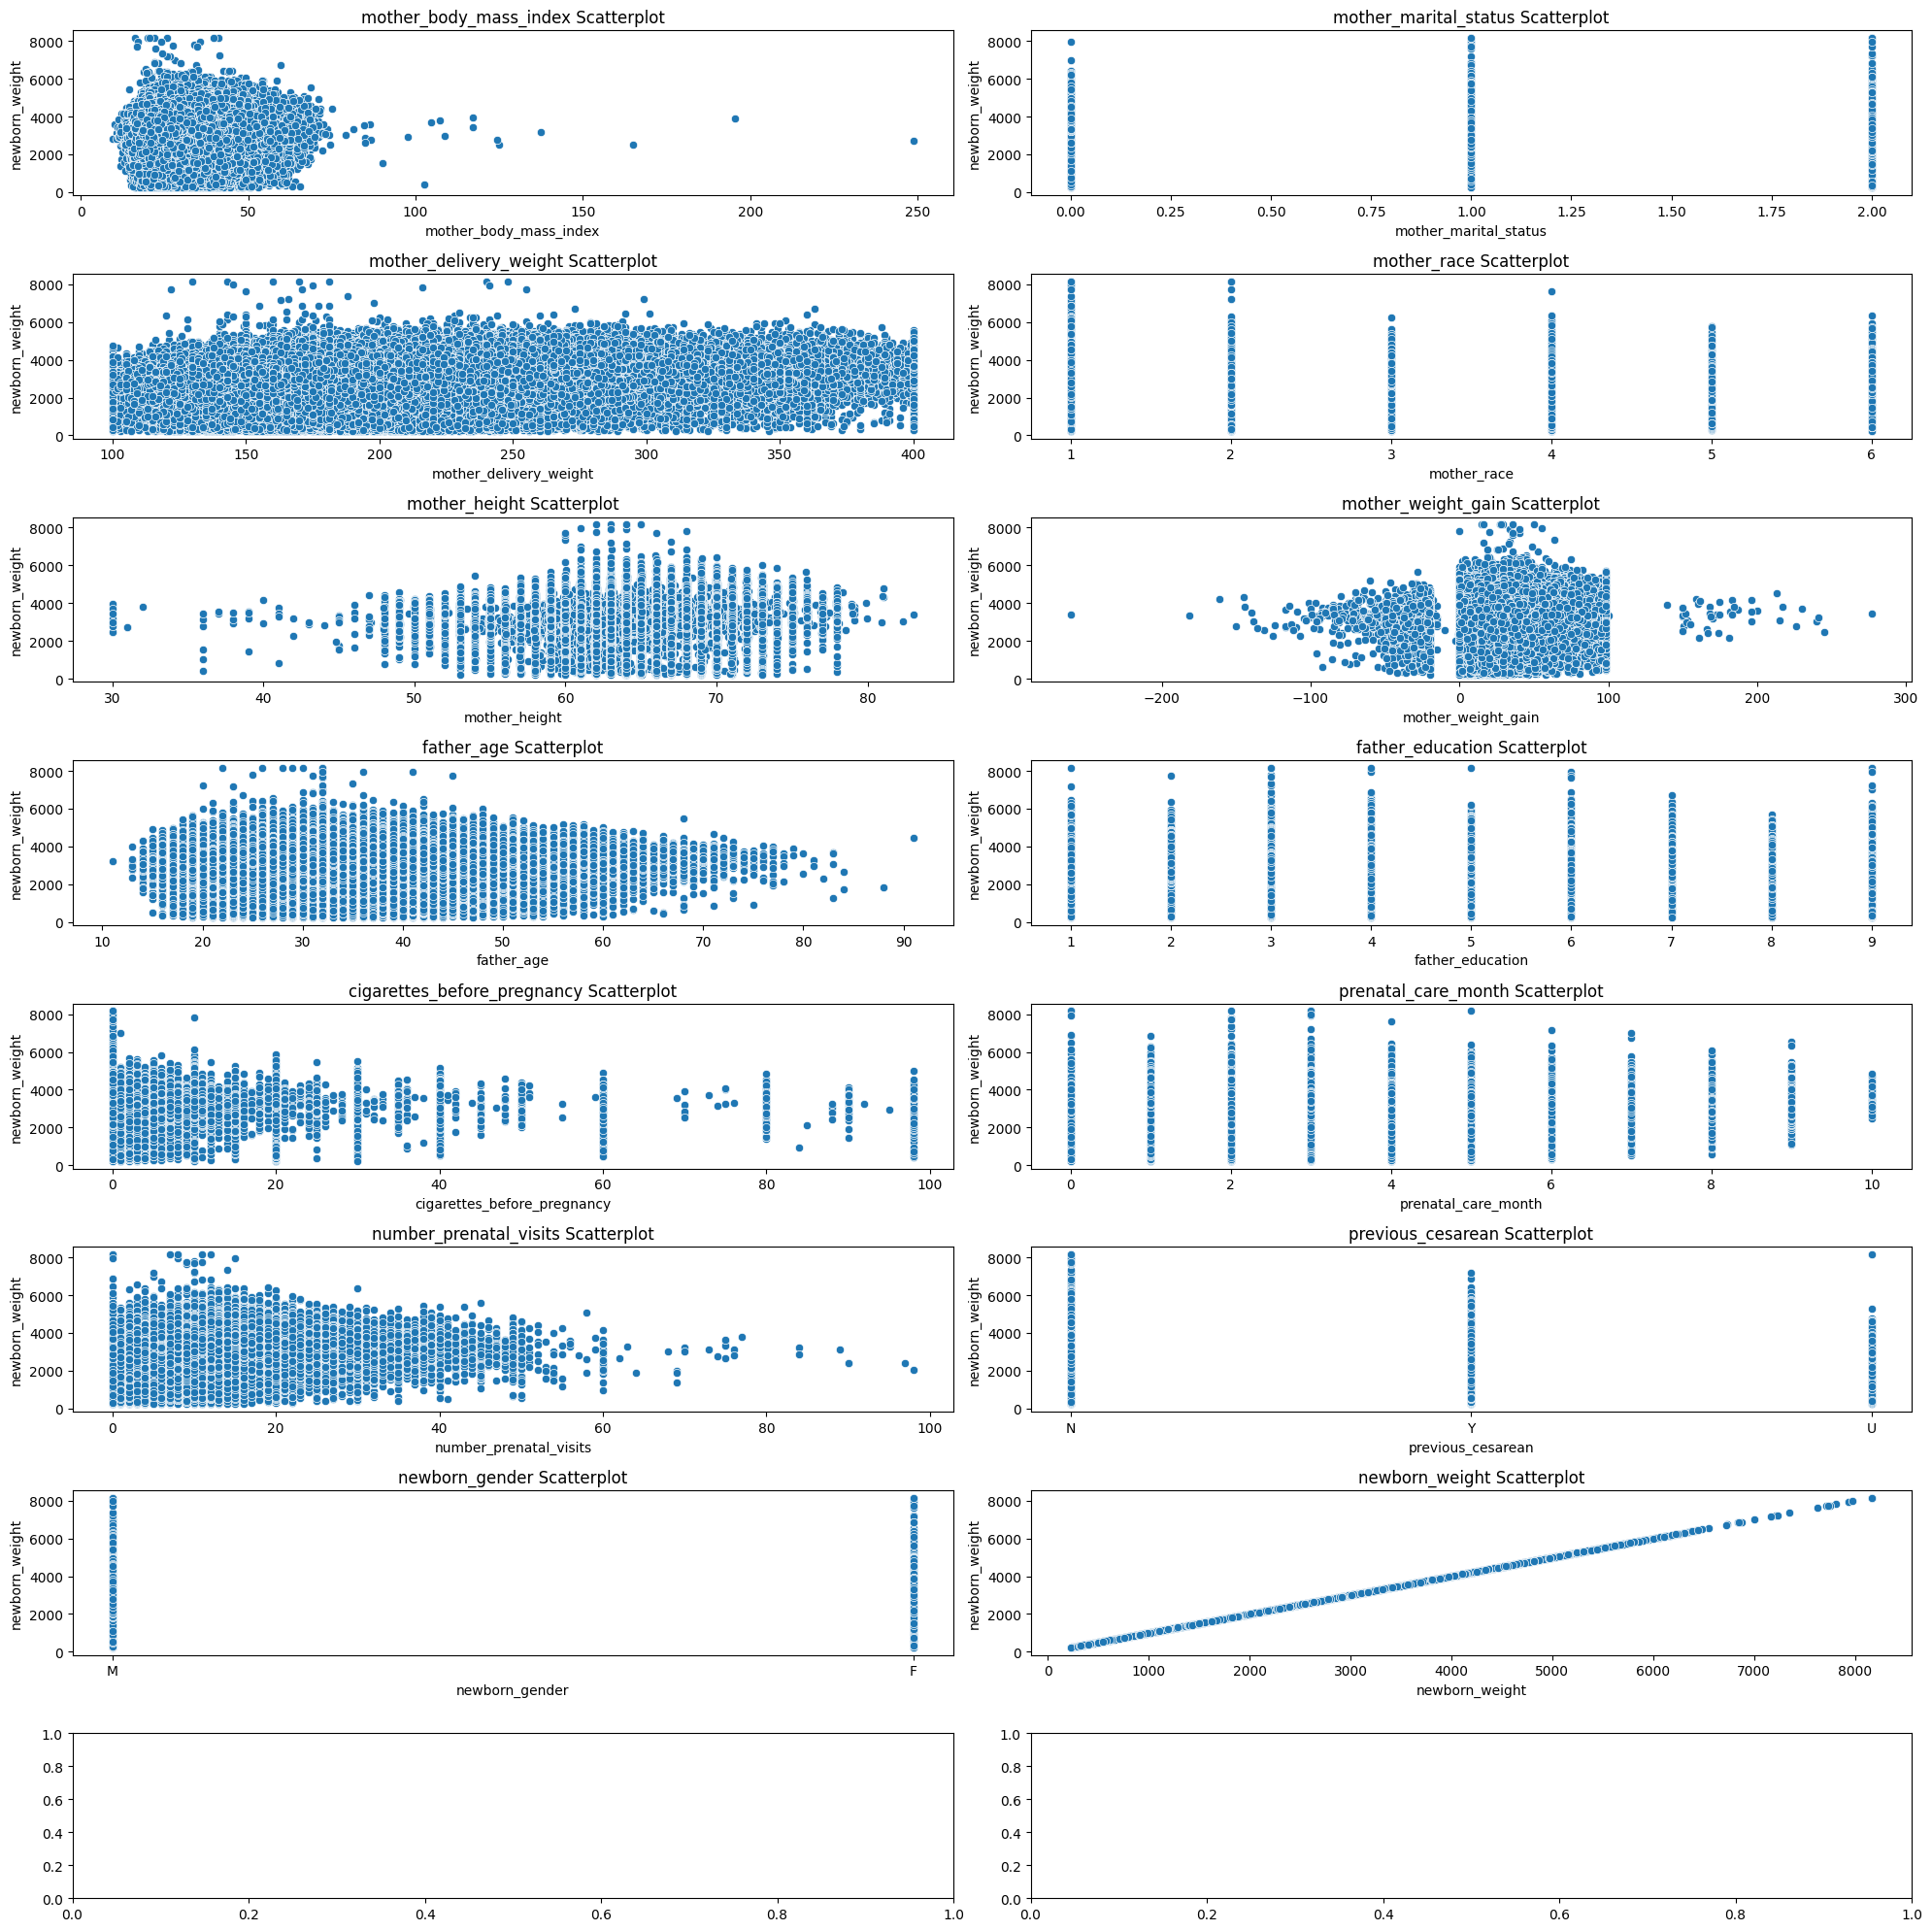

In [127]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

# Flatten the axes array
axes = axes.flatten()

columns = df.columns

# Iterate over each column and create scatterplots
for i, column in enumerate(columns):
    # Select the current axis
    ax = axes[i]

    # Create the scatterplot of the current column against 'newborn_weight'
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)

    # Set the title and labels
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

# Adjust the layout and spacing of subplots
plt.tight_layout()
plt.show()

### Deleting outliers

In [128]:
df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
df.loc[df['father_age'] > 80, 'father_age'] = 80
df.loc[df['mother_height'] < 45, 'mother_height'] = 45
df['mother_delivery_weight_log'] = np.log(df['mother_delivery_weight'])
df['mother_body_mass_index_log'] = np.log(df['mother_body_mass_index'])

In [129]:
# Encode mother_marital_status
df = pd.get_dummies(df, columns=['mother_marital_status'])
df.rename(columns={'mother_marital_status_1': 'mother_marital_status_married', 
                   'mother_marital_status_2': 'mother_marital_status_not_married'}, inplace=True)

# Encode mother_race
race_mapping = {
    1: 'White',
    2: 'Black',
    3: 'AIAN',
    4: 'Asian',
    5: 'NHOPI',
    6: 'More than one race'
}
df = pd.get_dummies(df, columns=['mother_race'])
df.rename(columns=race_mapping, inplace=True)

# Encode father_education
education_mapping = {
    1: 'Primary education',
    2: 'Primary education',
    3: 'Medium education',
    4: 'Medium education',
    5: 'Medium education',
    6: 'Higher education',
    7: 'Higher education',
    8: 'Professional education',
    9: 'Professional education'
}
df['father_education'] = df['father_education'].map(education_mapping)

# Encode father_education using one-hot encoding
df = pd.get_dummies(df, columns=['father_education'])
df['prenatal_care_month'] = df['prenatal_care_month'].replace(99, 0)
df['previous_cesarean'] = df['previous_cesarean'].map({'Y': 1, 'N': 0, 'U': 0})
encoded_columns = pd.get_dummies(df['prenatal_care_month'], prefix='prenatal_care')
encoded_columns.columns = ['prenatal_care_' + str(col) for col in encoded_columns.columns]
df = pd.concat([df, encoded_columns], axis=1)
df['mother_weight_lost'] = (df['mother_weight_gain'] < 0).astype(int)
df['mother_weight_moderate_gain'] = ((df['mother_weight_gain'] >= 0) & (df['mother_weight_gain'] < 110)).astype(int)
df['mother_weight_extra_gain'] = (df['mother_weight_gain'] >= 110).astype(int)
df['newborn_gender'] = (df['newborn_gender'] == 'M').astype(int)





In [130]:
df = df.reset_index(drop=True)


In [131]:
# Getting the number of missing values in each column
num_missing = df.isna().sum()
# Excluding columns that contains 0 missing values
num_missing = num_missing[num_missing > 0]

# Getting the percentages of missing values
percent_missing = num_missing * 100 / df.shape[0]
# Concatenating the number and percentage of missing values 
# into one dataframe and sorting it
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)


,Missing Values,Percentage


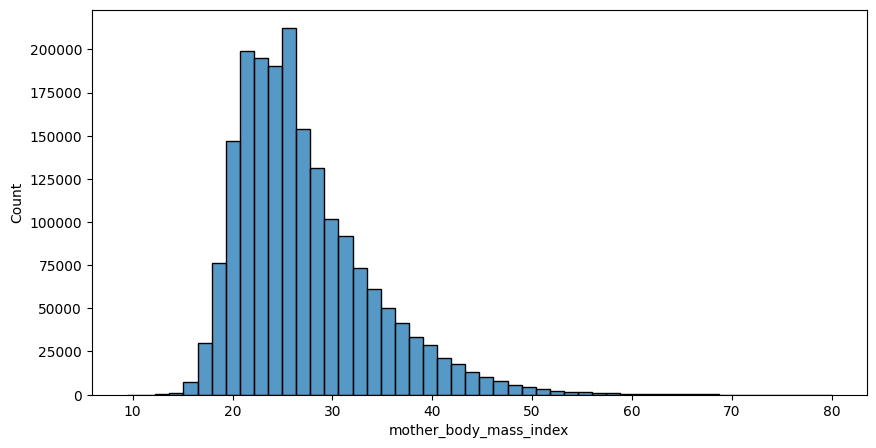

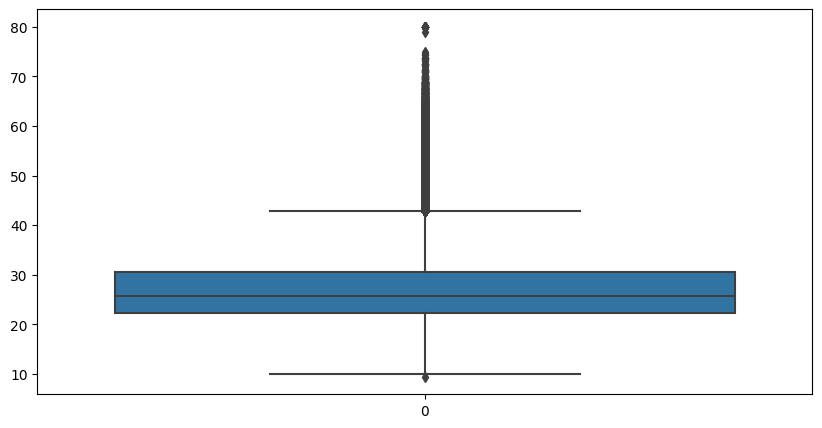

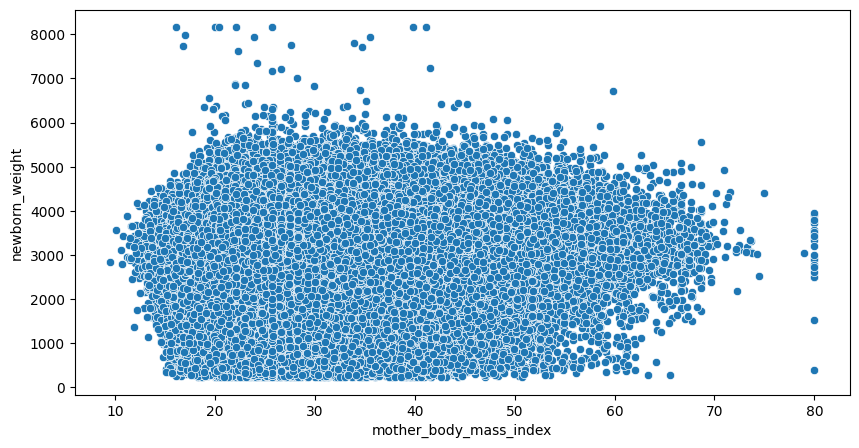

In [132]:
quick_viz(df['mother_body_mass_index'])

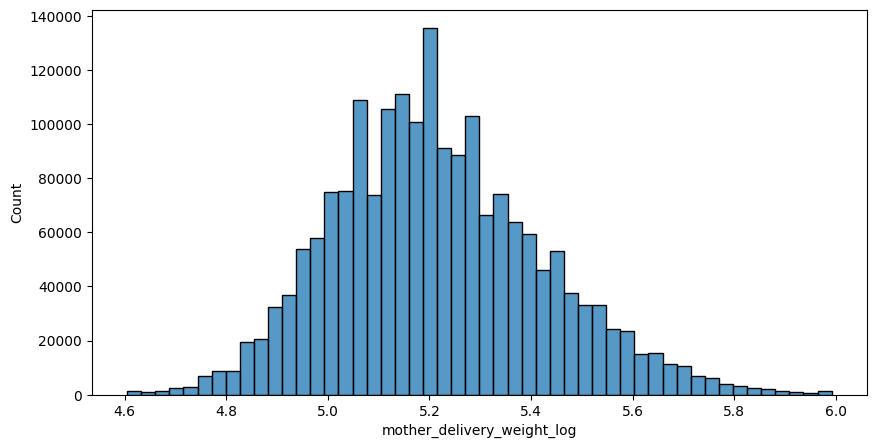

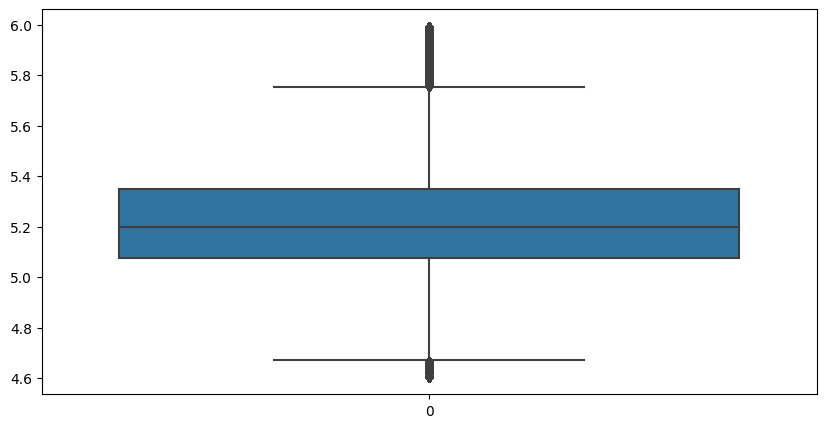

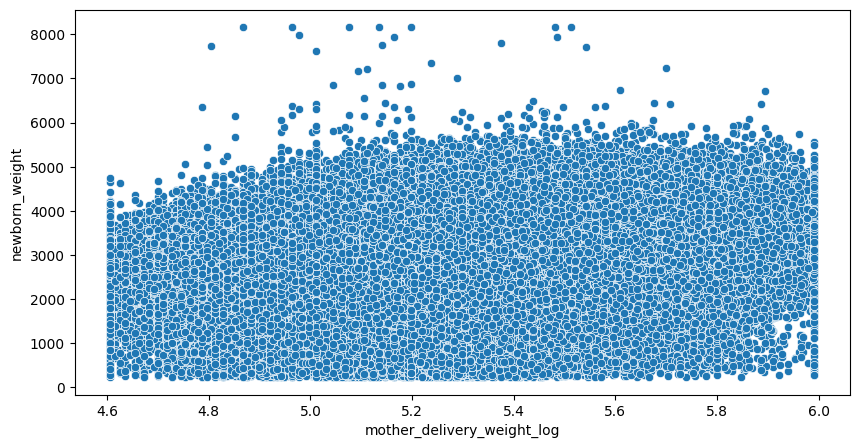

In [133]:
quick_viz(df['mother_delivery_weight_log'])

In [134]:
print(df.columns)

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy',
       'prenatal_care_month', 'number_prenatal_visits', 'previous_cesarean',
       'newborn_gender', 'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_0.0',
       'mother_marital_status_1.0', 'mother_marital_status_2.0',
       'mother_race_1', 'mother_race_2', 'mother_race_3', 'mother_race_4',
       'mother_race_5', 'mother_race_6', 'father_education_Higher education',
       'father_education_Medium education',
       'father_education_Primary education',
       'father_education_Professional education',
       'prenatal_care_prenatal_care_0', 'prenatal_care_prenatal_care_1',
       'prenatal_care_prenatal_care_2', 'prenatal_care_prenatal_care_3',
       'prenatal_care_prenatal_care_4', 'prenatal_care_prenatal_care_5',
       'prenatal_care_prenatal_care_6', 'prenatal_care_pre

In [135]:
df.sample(10)

,mother_body_mass_index,mother_delivery_weight,mother_height,mother_weight_gain,father_age,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,...,prenatal_care_prenatal_care_4,prenatal_care_prenatal_care_5,prenatal_care_prenatal_care_6,prenatal_care_prenatal_care_7,prenatal_care_prenatal_care_8,prenatal_care_prenatal_care_9,prenatal_care_prenatal_care_10,mother_weight_lost,mother_weight_moderate_gain,mother_weight_extra_gain
234975,25.7,190.0,63.0,45.0,50.0,0.0,2,12.0,0,0,...,False,False,False,False,False,False,False,0,1,0
1612355,34.3,233.0,64.0,33.0,21.0,0.0,3,14.0,0,1,...,False,False,False,False,False,False,False,0,1,0
1776240,27.4,206.0,66.0,36.0,32.0,0.0,3,14.0,0,1,...,False,False,False,False,False,False,False,0,1,0
1058193,23.4,145.0,62.0,17.0,31.0,0.0,2,21.0,0,1,...,False,False,False,False,False,False,False,0,1,0
531383,20.0,136.0,63.0,23.0,24.0,0.0,3,10.0,0,1,...,False,False,False,False,False,False,False,0,1,0
1606227,39.0,238.0,63.0,18.0,28.0,0.0,2,13.0,0,0,...,False,False,False,False,False,False,False,0,1,0
1384695,23.7,179.0,64.0,41.0,32.0,0.0,2,11.0,0,1,...,False,False,False,False,False,False,False,0,1,0
1833493,26.4,181.0,61.0,29.0,34.0,0.0,0,0.0,0,0,...,False,False,False,False,False,False,False,0,1,0
1121411,25.9,173.0,61.0,36.0,37.0,0.0,2,15.0,0,0,...,False,False,False,False,False,False,False,0,1,0
1835760,21.6,151.0,62.0,33.0,32.0,0.0,2,30.0,0,1,...,False,False,False,False,False,False,False,0,1,0


## Feature Selection

In [136]:
df.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy',
       'prenatal_care_month', 'number_prenatal_visits', 'previous_cesarean',
       'newborn_gender', 'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_0.0',
       'mother_marital_status_1.0', 'mother_marital_status_2.0',
       'mother_race_1', 'mother_race_2', 'mother_race_3', 'mother_race_4',
       'mother_race_5', 'mother_race_6', 'father_education_Higher education',
       'father_education_Medium education',
       'father_education_Primary education',
       'father_education_Professional education',
       'prenatal_care_prenatal_care_0', 'prenatal_care_prenatal_care_1',
       'prenatal_care_prenatal_care_2', 'prenatal_care_prenatal_care_3',
       'prenatal_care_prenatal_care_4', 'prenatal_care_prenatal_care_5',
       'prenatal_care_prenatal_care_6', 'prenatal_care_pre

In [137]:
x_col = ['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy',
       'prenatal_care_month', 'number_prenatal_visits', 'previous_cesarean',
       'newborn_gender',  'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_0.0',
       'mother_marital_status_1.0', 'mother_marital_status_2.0',
       'mother_race_1', 'mother_race_2', 'mother_race_3', 'mother_race_4',
       'mother_race_5', 'mother_race_6', 'father_education_Higher education',
       'father_education_Medium education',
       'father_education_Primary education',
       'father_education_Professional education',
       'prenatal_care_prenatal_care_0', 'prenatal_care_prenatal_care_1',
       'prenatal_care_prenatal_care_2', 'prenatal_care_prenatal_care_3',
       'prenatal_care_prenatal_care_4', 'prenatal_care_prenatal_care_5',
       'prenatal_care_prenatal_care_6', 'prenatal_care_prenatal_care_7',
       'prenatal_care_prenatal_care_8', 'prenatal_care_prenatal_care_9',
       'prenatal_care_prenatal_care_10', 'mother_weight_lost',
       'mother_weight_moderate_gain', 'mother_weight_extra_gain']

In [138]:
y_col = ['newborn_weight']

In [139]:
x_train = df.drop('newborn_weight', axis=1)  # Remove the 'newborn_weight' column
y_train = df['newborn_weight'] 

In [140]:
sel = VarianceThreshold(0.01)
sel_var = sel.fit_transform(df[x_col])
col_imp = df[x_col][df[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(df[x_col].columns.tolist()) - set(col_imp)


In [141]:
col_redundant
general_ranking = pd.DataFrame(index=x_col)

In [142]:
scaler = StandardScaler()


sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=10))
sel_.fit(scaler.transform(x_train), y_train)
sel_.get_feature_names_out()

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Boruta

In [ ]:

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)


In [ ]:
feat_selector = bp(rf, n_estimators="auto", verbose=0, max_iter=100)

In [143]:
feat_selector.fit(x_train, y_train.ravel())

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
elastic = ElasticNet(alpha=0.2, l1_ratio=0.5)
elastic.fit(df.loc[:, x_col], df.loc[:, y_col])
coef = pd.Series(elastic.coef_, index=df.loc[:, x_col].columns)
print(
    "Elastic Net picked "
    + str(sum(coef != 0))
    + " variables and eliminated the other "
    + str(sum(coef == 0))
    + " variables"
)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
plt.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Elastic Net Model")